# Data acquisition

<Figure size 432x288 with 0 Axes>

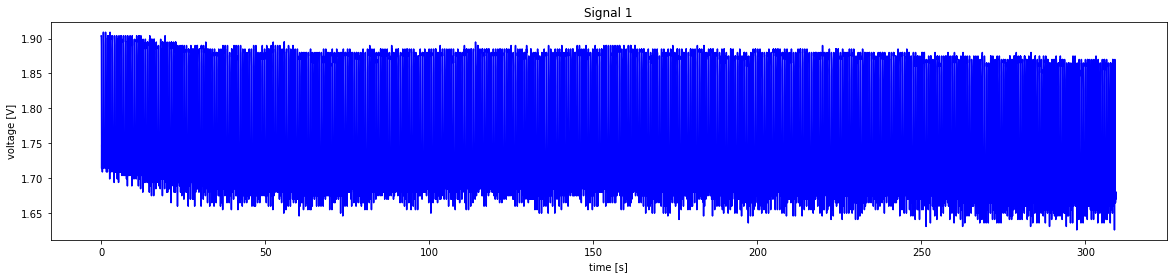

<Figure size 432x288 with 0 Axes>

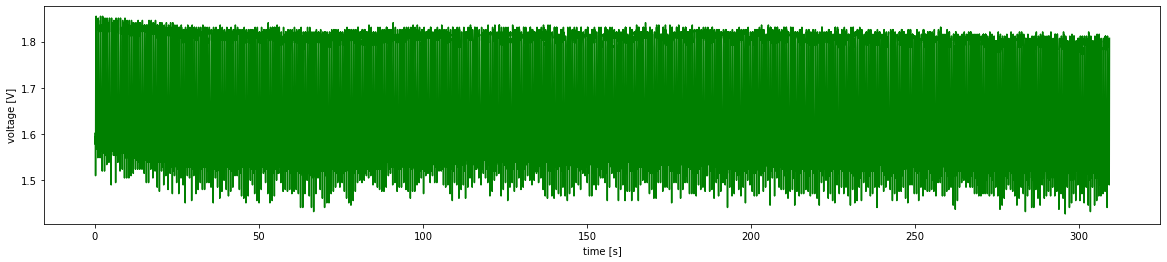

In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
#%matplotlib notebook

sig1=[]
sig2=[]
t = []
i=0

# Data acquisition 
with open('C:/Users/Marco/Desktop/T-junction/T-data/18-11/B-ol25-aq15-pause10.csv') as data:
    for sig in csv.reader(data, delimiter='	'):
        #print(sig)
        sig[0] = sig[0].replace('.','').replace(',','.')
        sig[1] = sig[1].replace('.','').replace(',','.')
        sig[2] = sig[2].replace('.','').replace(',','.')
        #print(sig)
        sig1.append(float(sig[0]))
        sig2.append(float(sig[1]))
        t.append(float(sig[2]))
sig1 = np.array(sig1)
sig1 = sig1[0:-1]
sig2 = np.array(sig2)
sig2 = sig2[0:-1]
t = np.array(t)
t = t[0:-1]        

# Plot signal 1
plt.figure()
plt.figure(figsize=(20,4))
plt.title('Signal 1')
plt.xlabel("time [s]")
plt.ylabel("voltage [V]")
plt.plot(t,sig1, color='blue')
plt.show()

# Plot signal 2
plt.figure()
plt.figure(figsize=(20,4))
plt.xlabel("time [s]")
plt.ylabel("voltage [V]")
plt.plot(t,sig2,color='green')
plt.show()


# Signals straightening

In [2]:
def signal_straightening(X_data, Y_data, color):
    
    #Linear fit
    from lmfit.models import LinearModel
    linear = LinearModel(prefix='lin_')
    pars = linear.make_params(slope = 0, intercept=1.6)
    init = linear.eval(pars, x=X_data)
    out = linear.fit(Y_data, pars, x=X_data)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    # Plot og original signal
    plt.title('Original signal')
    plt.ylabel("voltage [V]")
    plt.xlabel("time [s]")
    axes[0].plot(X_data, Y_data, color)
    axes[0].plot(t, out.init_fit, 'k--', label='initial fit')
    axes[0].plot(t, out.best_fit, 'r-', label='best fit')
    axes[0].legend(loc='best')
    
    
    # Plot of rotated signal
    slope=out.best_values.get('lin_slope')
    Y_data[:]=Y_data[:]-slope*X_data[:]
    plt.title('Rotated signal')
    plt.xlabel("time [s]")
    plt.ylabel("voltage [V]")    
    axes[1].plot(X_data, Y_data, color)

### Signal 1 

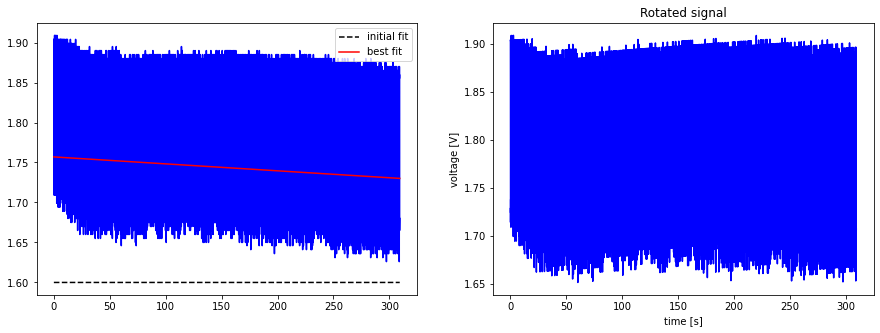

In [3]:
signal_straightening(t, sig1, 'blue')

### Signal 2

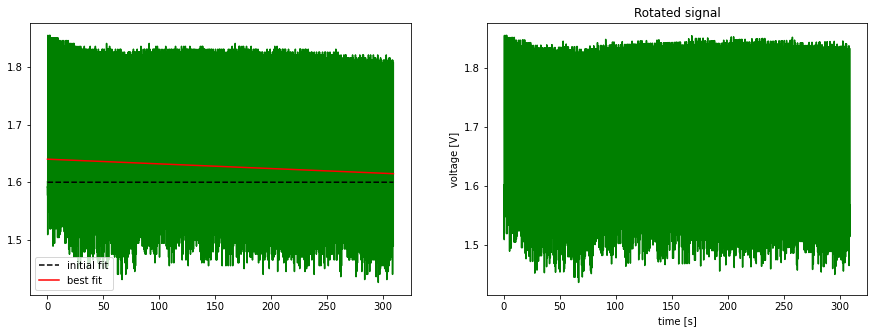

In [4]:
signal_straightening(t, sig2, 'green')

# Thresholds computing

In [5]:
def thr_searcher(Data, nbins, thr_low, thr_high, color):
    
    # Histogram definition
    freq,bins,p = plt.hist(Data, nbins, color=color)
    x = 0.5 *(bins[:-1] + bins[1:])
    plt.clf() # Clear figure
    
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    from lmfit.models import GaussianModel

    #Cicle changing center1 position if condition (center1+2*sigma1 < center2-2*sigma2) is not fulfilled
    for i in range(1,6):    

        #linear = LinearModel(prefix='lin_')
        gauss1 = GaussianModel(prefix='g1_')
        pars = gauss1.make_params(center=x[0]+i*(x[-1]-x[0])/10, sigma=(x[-1]-x[0])/15 , amplitude=max(freq)/20)

        #gauss1 = GaussianModel(prefix='g1_')
        #pars.update(gauss1.make_params())

        gauss2 = GaussianModel(prefix='g2_')
        pars.update(gauss2.make_params())

        pars['g1_center'].set(max = x[0]+(x[-1]-x[0])*0.7, min=min(x))
        pars['g1_sigma'].set(max=(x[-1]-x[0])/10,min=(x[-1]-x[0])/30)
        #pars['g1_amplitude'].set(value=max(freq)/20,min=10)

        pars['g2_center'].set(value=x[-1]*0.98)
        pars['g2_sigma'].set(value=(x[-1]-x[0])/15)
        pars['g2_amplitude'].set(value=max(freq)/20,min=10)

        #mod = linear + gauss1 +gauss2
        mod = gauss1 +gauss2

        init = mod.eval(pars, x=x)
        out = mod.fit(freq, pars, x=x)

        # Plot histo
        axes[0].hist(Data, nbins, color=color)
        axes[0].plot(x, out.init_fit, 'k--', label='initial fit')
        axes[0].plot(x, out.best_fit, 'r-', label='best fit')
        axes[0].legend(loc='best')
        plt.xlabel("voltage [V]")
        plt.ylabel("number of events")

        center2=out.best_values.get('g2_center')
        sigma2=out.best_values.get('g2_sigma')
        center1=out.best_values.get('g1_center')
        sigma1=out.best_values.get('g1_sigma')

        if center1+2*sigma1 < center2-2*sigma2:
            max_freq1=max(freq[x<center1+sigma1])
            x_max1 = x[np.argmax(freq[x<center1+2*sigma1])]
            max_freq2=max(freq[x>center2-sigma2])
            a=x>center2-sigma2
            freq2=np.zeros(len(freq))
            for i in range(len(a)): 
                if a[i]==True: freq2[i]=freq[i]
            #print(freq2)
            x_max2 = x[np.argmax(freq2)]
            #print('xmax 1: ', x_max1,'\n xmax 2: ',x_max2)
            break
        else: print('trying again')
            
    thr_low  = x_max1 + 2*sigma1
    thr_high = x_max2 - 2*sigma1
    print('thr_low = ', thr_low,' [V] \n thr_high = ', thr_high, ' [V]')
    
    axes[1].plot(t, Data, color)
    axes[1].plot(thr_high*np.ones(len(t)), color='red')
    axes[1].plot(thr_low*np.ones(len(t)), color='red')
    plt.xlim((0,t[len(t)-1]))
    plt.ylabel("voltage [V]")
    plt.xlabel("time [s]")
    
    return thr_low, thr_high

### Signal 1

thr_low =  1.7391278785630375  [V] 
 thr_high =  1.8574613126629311  [V]


<Figure size 432x288 with 0 Axes>

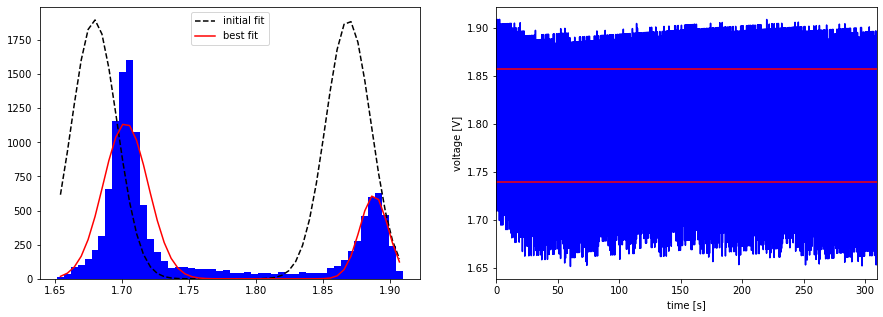

In [6]:
thr_low_1  = 0.0
thr_high_1 = 0.0
thr_low_1, thr_high_1 = thr_searcher(sig1, 50, thr_low_1, thr_high_1, 'blue')

### Signal 2

thr_low =  1.5932907850638207  [V] 
 thr_high =  1.782080256207573  [V]


<Figure size 432x288 with 0 Axes>

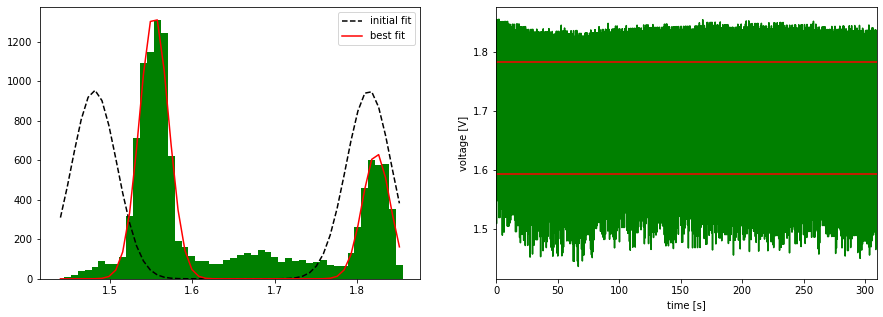

In [7]:
thr_low_2  = 0.0
thr_high_2 = 0.0
thr_low_2, thr_high_2 = thr_searcher(sig2, 50, thr_low_2, thr_high_2, 'green')

# Drops detection

In [17]:
#definisco una goccia da quando il segnale sale sopra la soglia alta a quando scende sotto la soglia bassa
def drop_det(time, data, thr_low, thr_high, drop_start, drop_end, ymin, ymax, xrange):
    
    # Drops edges computing
    bool_high  = data > thr_high
    bool_low   = data < thr_low
    drop_start = [0]
    drop_end   = [1]
   
    for i in range(len(data)-1):
        
        if bool_high[i]==False and bool_low[i+1]==False and bool_high[i+1]==True:
            if drop_start[-1:] < drop_end[-1:]:
                drop_start.append(i)
                
        elif bool_low[i]==False and bool_low[i+1]==True and bool_high[i+1]==False:
            if drop_start[-1:] > drop_end[-1:]:
                drop_end.append(i)
 
    # number acquisition -> time [s] conversion
    drop_start = time[drop_start]
    drop_end   = time[drop_end]
    
    # Plotting 
    for j in range(int (time[-1]/xrange)):
        plt.figure()
        plt.figure(figsize=(20,4))
        for i in range(len(drop_end)):
        
            plt.vlines(drop_start[i], ymin, ymax, color='green')
            plt.vlines(drop_end[i], ymin, ymax, color='red')

        plt.plot(time, data)
        plt.ylabel("Voltage [V]")
        plt.xlabel("Time [s]")
        plt.xlim(j*xrange,(j+1)*xrange)
        plt.ylim(ymin, ymax)
        plt.show()
        
    return drop_start, drop_end
    
    

### Signal 1

<Figure size 432x288 with 0 Axes>

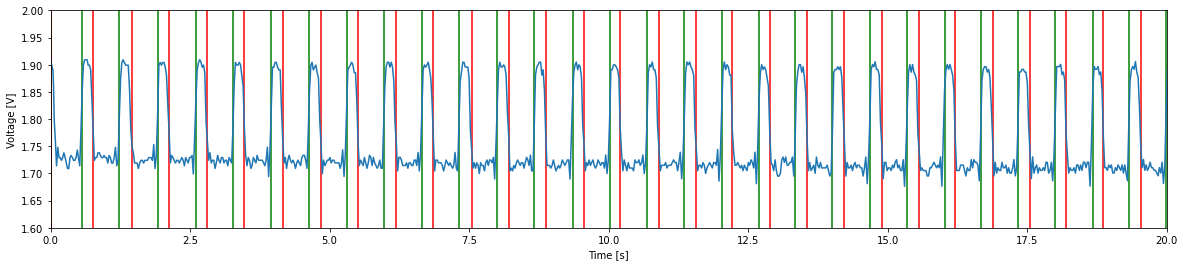

<Figure size 432x288 with 0 Axes>

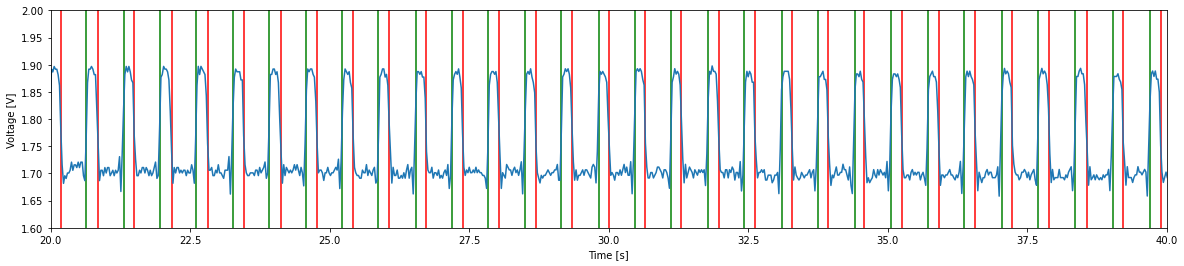

<Figure size 432x288 with 0 Axes>

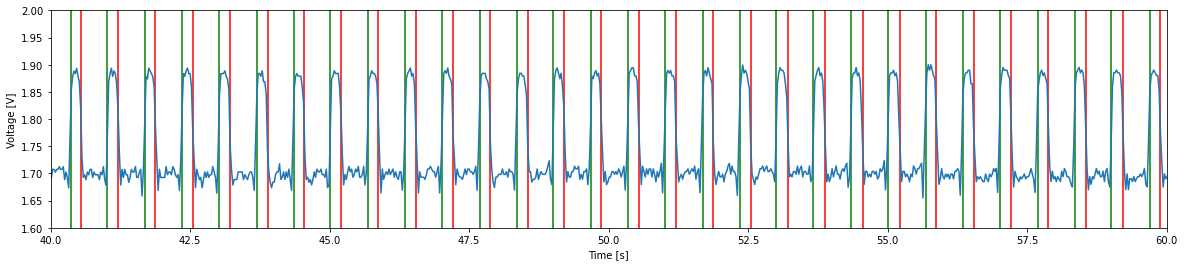

<Figure size 432x288 with 0 Axes>

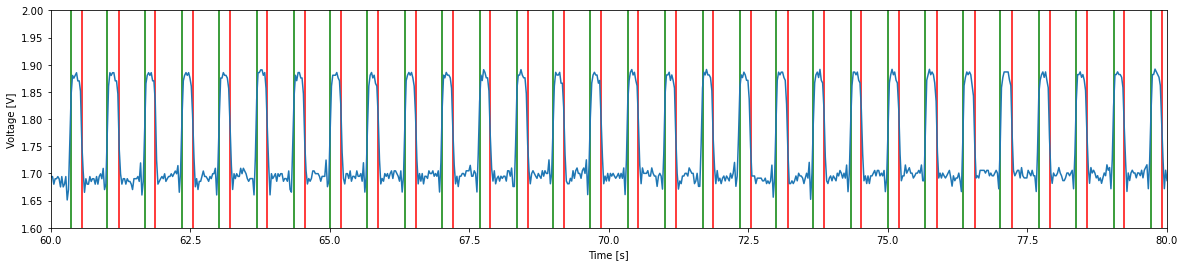

<Figure size 432x288 with 0 Axes>

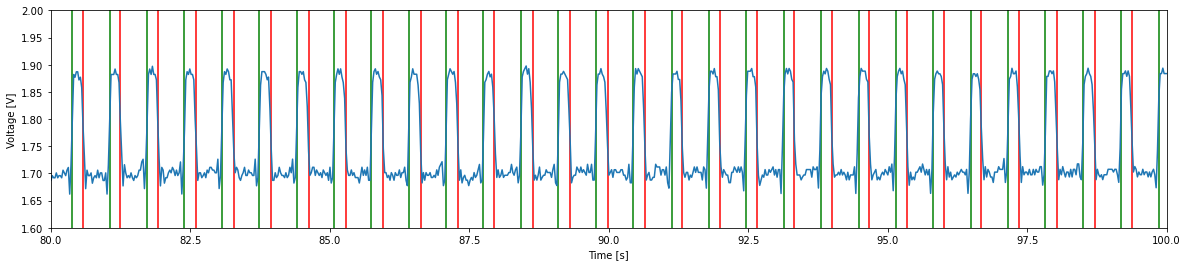

<Figure size 432x288 with 0 Axes>

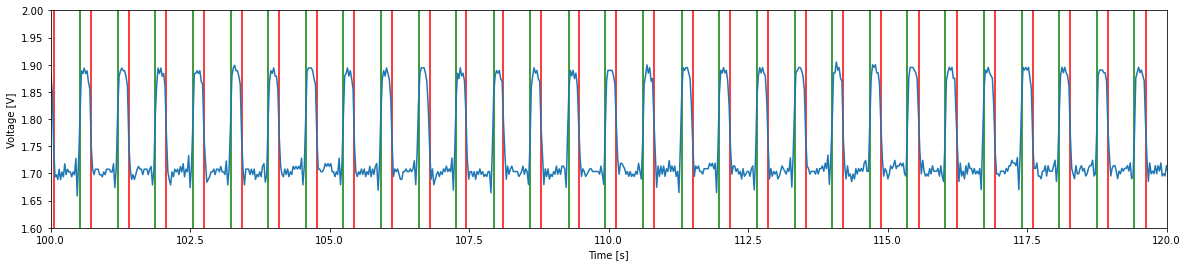

<Figure size 432x288 with 0 Axes>

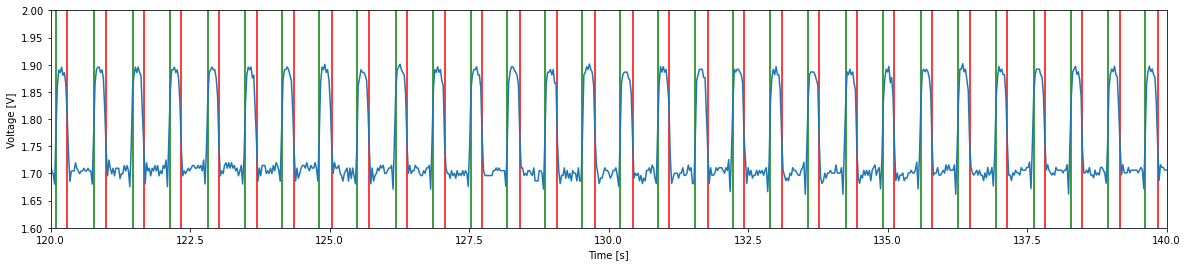

<Figure size 432x288 with 0 Axes>

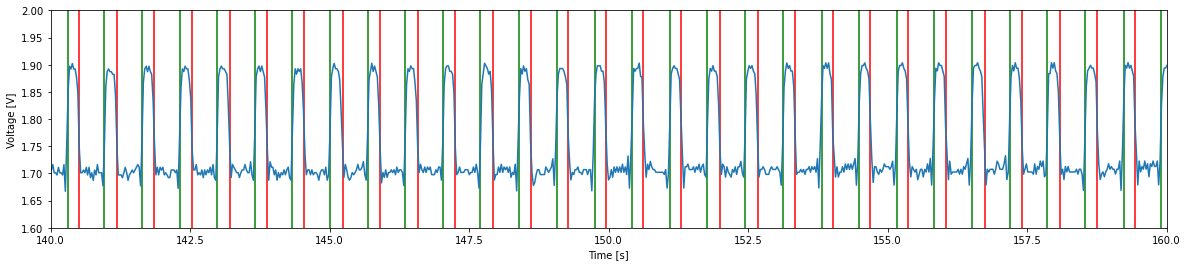

<Figure size 432x288 with 0 Axes>

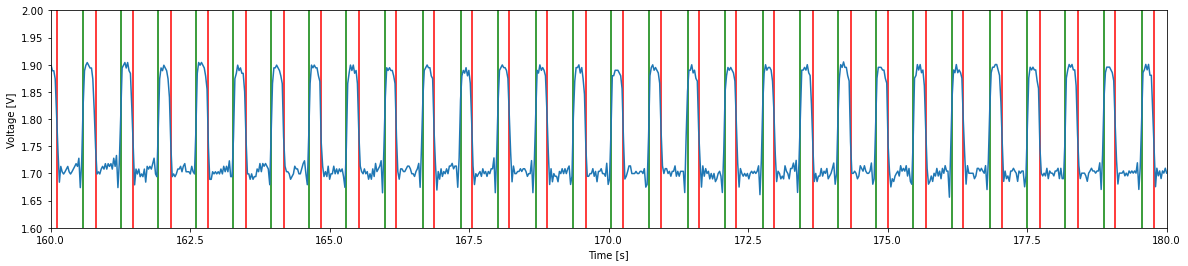

<Figure size 432x288 with 0 Axes>

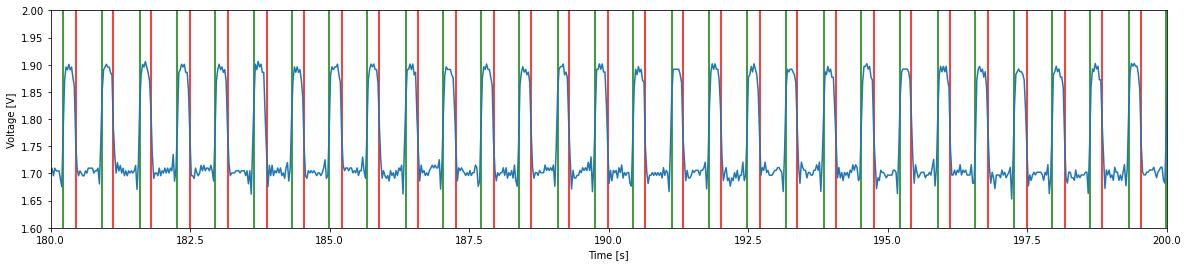

<Figure size 432x288 with 0 Axes>

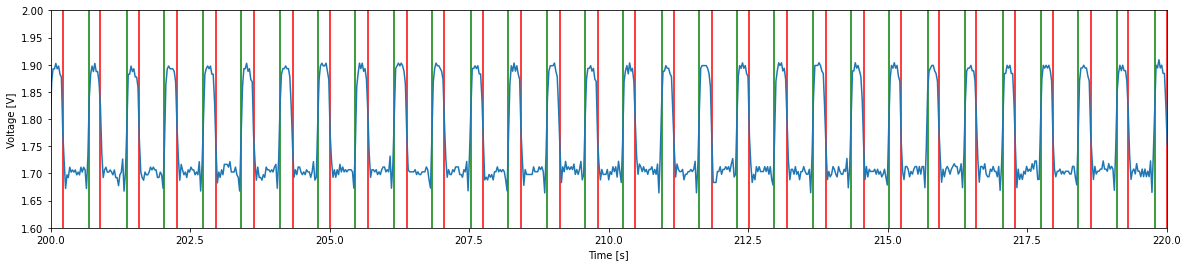

<Figure size 432x288 with 0 Axes>

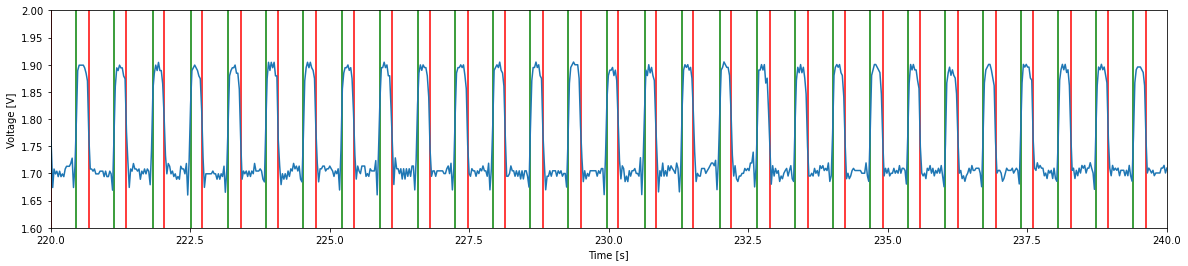

<Figure size 432x288 with 0 Axes>

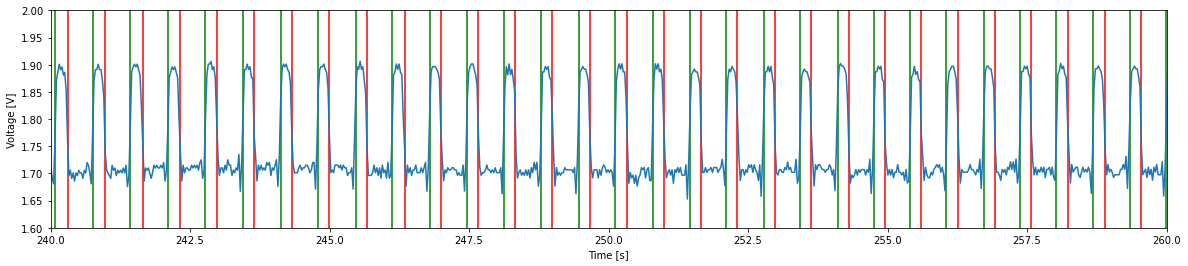

<Figure size 432x288 with 0 Axes>

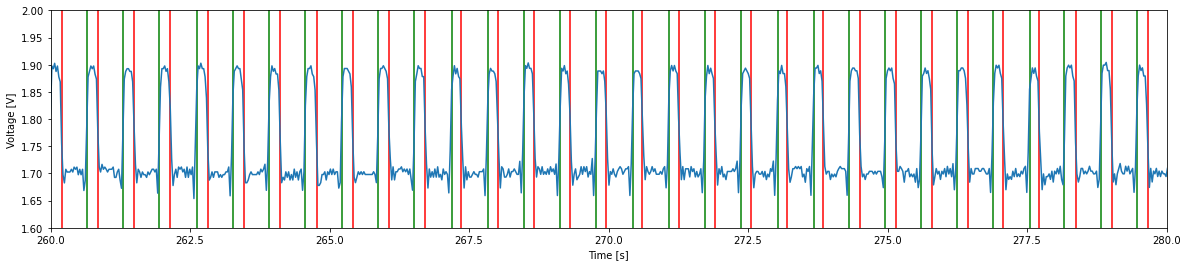

<Figure size 432x288 with 0 Axes>

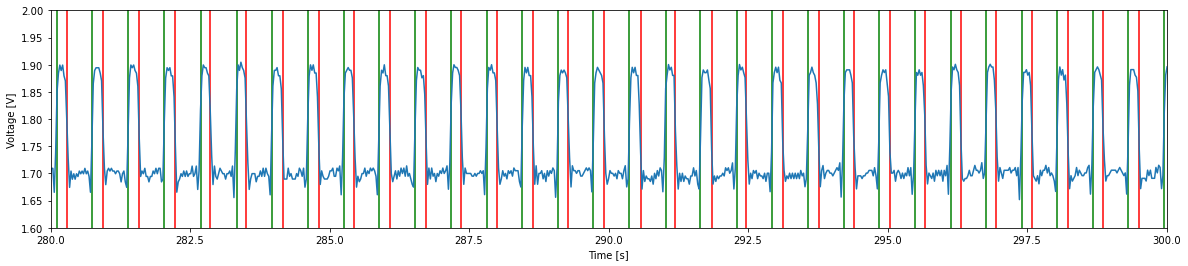

In [18]:
drop_start_1 = np.zeros(100)
drop_end_1   = np.zeros(100)
ymin         = 1.6            # plot y min. [V]
ymax         = 2.0            # plot y max. [V]
xrange       = 20            # single plot x range
drop_start_1, drop_end_1 = drop_det(t, sig1, thr_low_1, thr_high_1, drop_start_1, drop_end_1, ymin, ymax, xrange)

### Signal 2

<Figure size 432x288 with 0 Axes>

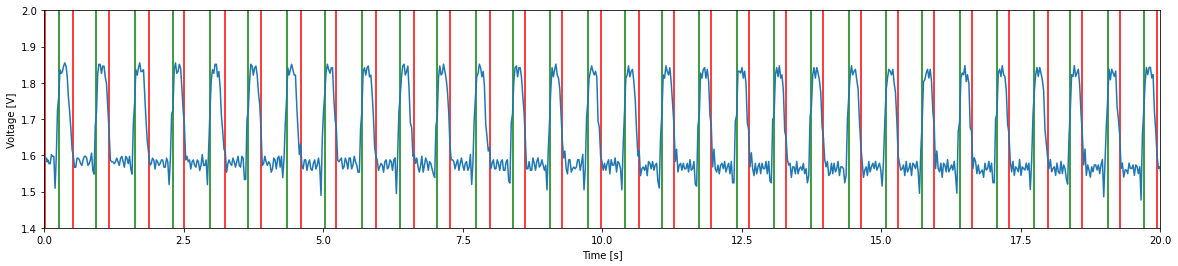

<Figure size 432x288 with 0 Axes>

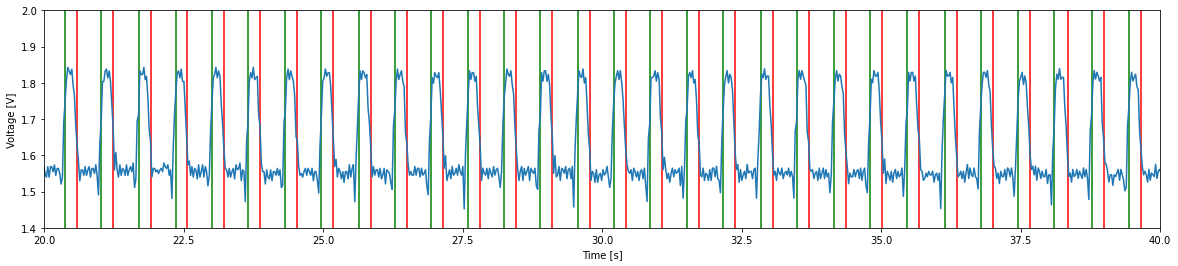

<Figure size 432x288 with 0 Axes>

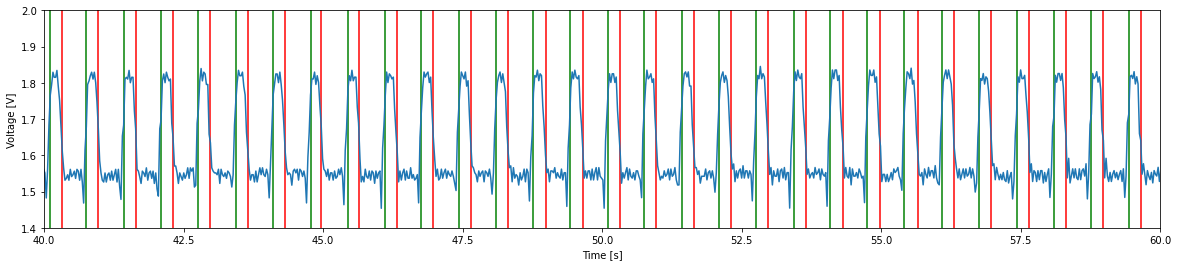

<Figure size 432x288 with 0 Axes>

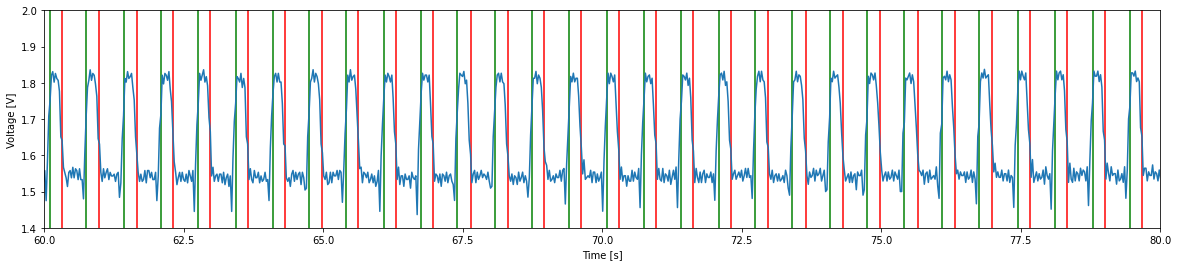

<Figure size 432x288 with 0 Axes>

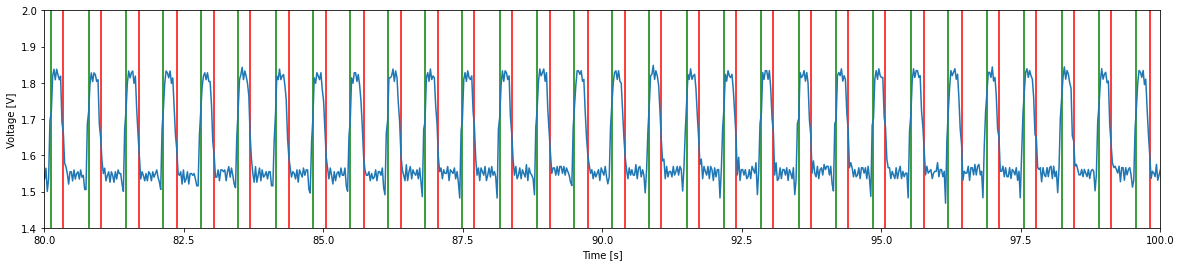

<Figure size 432x288 with 0 Axes>

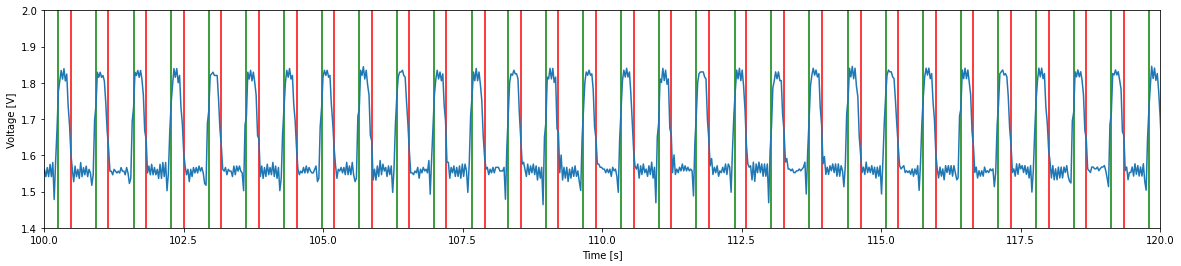

<Figure size 432x288 with 0 Axes>

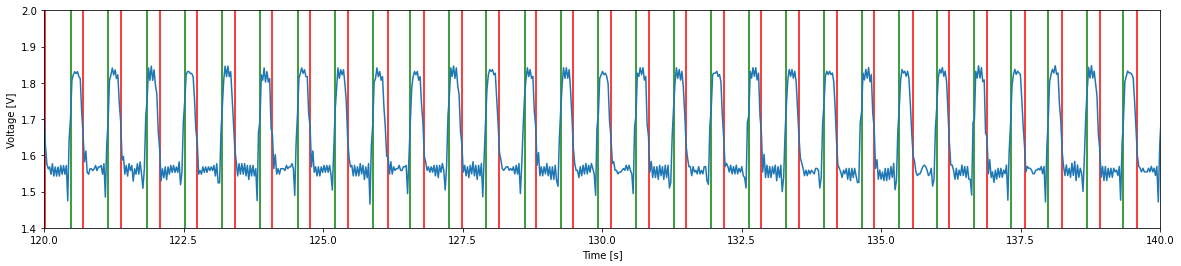

<Figure size 432x288 with 0 Axes>

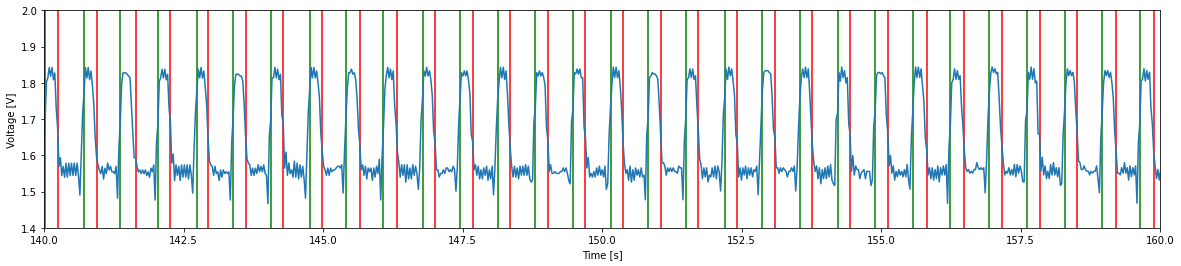

<Figure size 432x288 with 0 Axes>

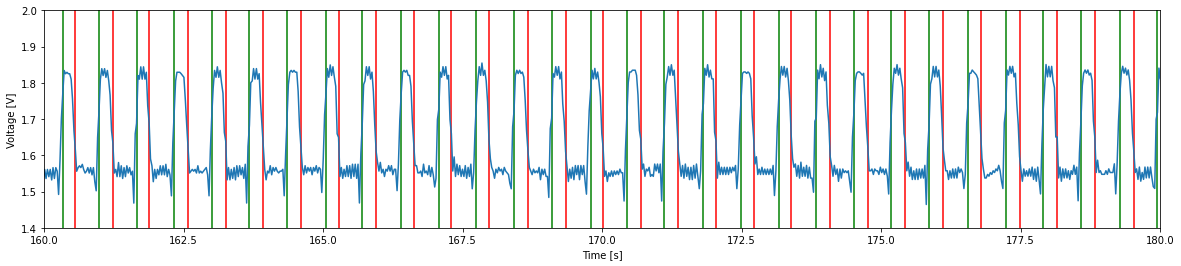

<Figure size 432x288 with 0 Axes>

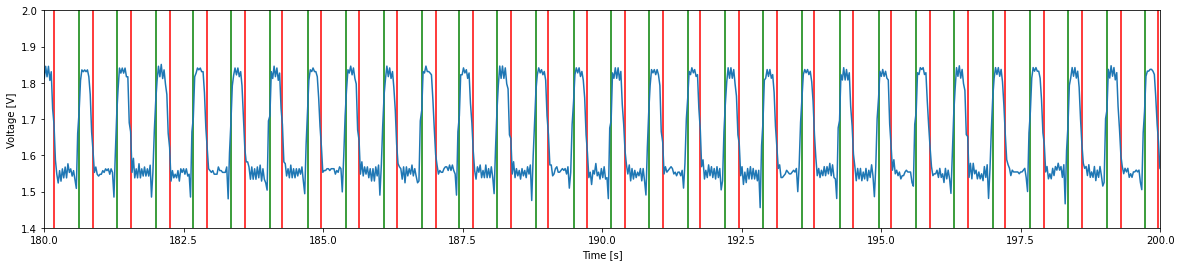

<Figure size 432x288 with 0 Axes>

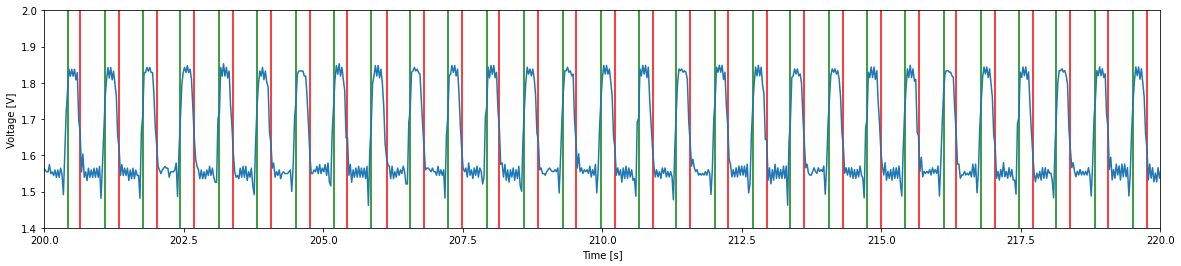

<Figure size 432x288 with 0 Axes>

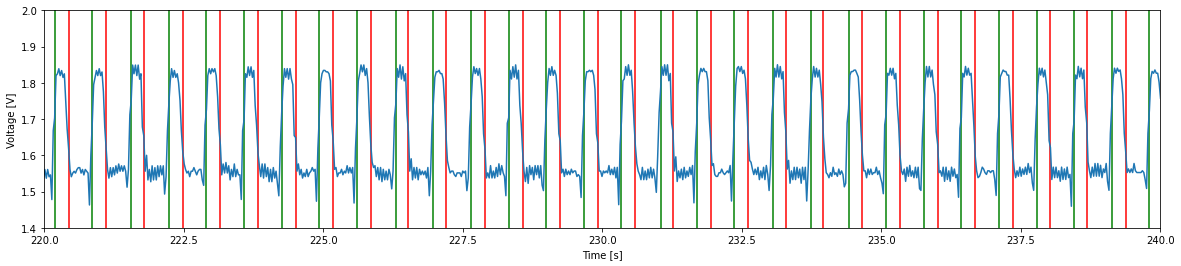

<Figure size 432x288 with 0 Axes>

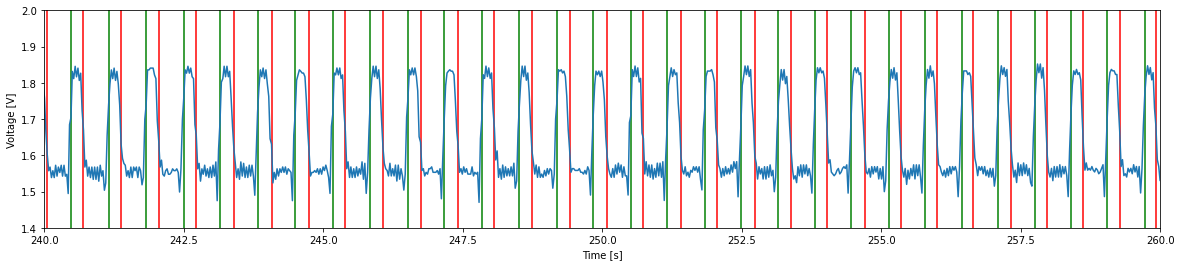

<Figure size 432x288 with 0 Axes>

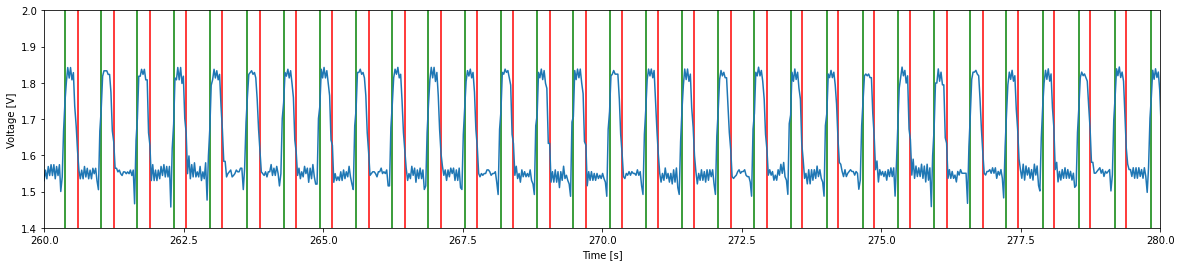

<Figure size 432x288 with 0 Axes>

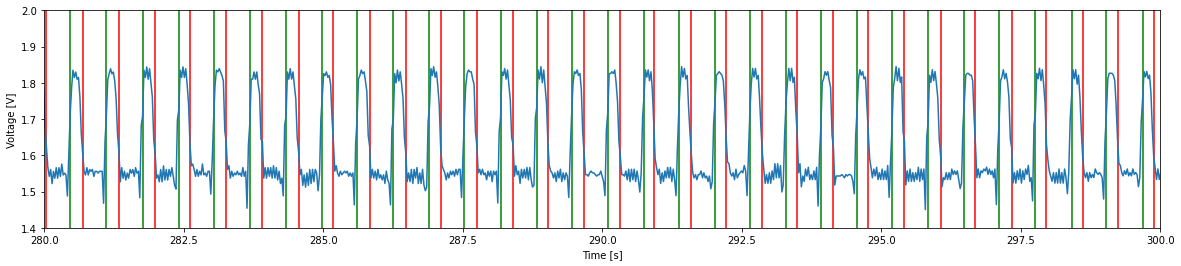

In [11]:
drop_start_2 = np.zeros(100)
drop_end_2   = np.zeros(100)
ymin         = 1.4            # plot y min. [V]
ymax         = 2.0            # plot y max. [V]
xrange       = 20            # single plot x range
drop_start_2, drop_end_2 = drop_det(t, sig2, thr_low_2, thr_high_2, drop_start_2, drop_end_2, ymin, ymax, xrange)